### imports

In [1]:
import random
import os
import csv

import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm

import clip
import nltk

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torchvision
from torchvision import transforms as T
from sklearn.model_selection import train_test_split

import kagglehub

In [2]:
class Colour:
    BLUE = '\033[94m'
    CYAN = '\033[96m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    END = '\033[0m'

vscode_bg = '#1e1e1e'
text_color = 'white'
grid_color = '#444444'

plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.monospace'] = ['Consolas', 'DejaVu Sans Mono', 'Courier New']
plt.rcParams['figure.facecolor'] = vscode_bg
plt.rcParams['axes.facecolor'] = vscode_bg
plt.rcParams['axes.edgecolor'] = text_color
plt.rcParams['axes.labelcolor'] = text_color
plt.rcParams['xtick.color'] = text_color
plt.rcParams['ytick.color'] = text_color
plt.rcParams['text.color'] = text_color
plt.rcParams['grid.color'] = grid_color

### load data

In [3]:
path = kagglehub.dataset_download("eeshawn/flickr30k")
print("Path to dataset files:", path)
nltk.download('punkt_tab')

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

Path to dataset files: /Users/valentin/.cache/kagglehub/datasets/eeshawn/flickr30k/versions/1


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/valentin/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Preprocess

### prepare data

In [4]:
class Vocab:
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0
        # specials tokens
        self.add_word('<pad>')
        self.add_word('<unk>')
        self.add_word('<start>')
        self.add_word('<end>')

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __len__(self):
        return len(self.word2idx)

    def encode(self, text):
        tokens = nltk.tokenize.word_tokenize(text.lower())
        return [self.word2idx.get(t, self.word2idx['<unk>']) for t in tokens]

In [5]:
class CaptionDataset(Dataset):
    def __init__(self, data_pairs, vocab, cache_dir):
        self.data_pairs = data_pairs
        self.vocab = vocab
        self.cache_dir = cache_dir
        
    def __len__(self): return len(self.data_pairs)
    
    def __getitem__(self, idx):
        img_path, caption = self.data_pairs[idx]
        filename = os.path.basename(img_path).split('.')[0] + ".pt"
        load_path = os.path.join(self.cache_dir, filename)
        
        try:
            cached = torch.load(load_path)
            feat = cached['features'] if isinstance(cached, dict) else cached
            if len(feat.shape) > 1: feat = feat[0]
        except FileNotFoundError:
            feat = torch.zeros(512) # fallback

        tokens = self.vocab.encode(caption)
        caption_indices = [self.vocab.word2idx['<start>']] + tokens + [self.vocab.word2idx['<end>']]
        return feat, torch.tensor(caption_indices, dtype=torch.long)

In [6]:
class DataManager:
    def __init__(self, dataset_path, img_folder_name="flickr30k_images", captions_filename="captions.txt", cache_dir="cached_features"):
        self.root = dataset_path
        self.img_folder = os.path.join(self.root, img_folder_name)
        self.captions_file = self._find_file(captions_filename)
        self.token_file = os.path.join(self.root, "flickr30k.token.txt")
        self.cache_dir = cache_dir
        self.vocab = Vocab()
        self.data_pairs = []
        
    def _find_file(self, name):
        for root, _, files in os.walk(self.root):
            if name in files: return os.path.join(root, name)
        return None

    def prepare_data(self, limit=None, vocab_max_size=None):
        """Pipeline complet : CSV -> Token -> Vocab -> Pairs"""
        if not os.path.exists(self.token_file):
            self._convert_csv_to_token()
            
        with open(self.token_file, 'r', encoding='utf-8') as f:
            lines = f.readlines()
            
        random.seed(42)
        random.shuffle(lines)
        
        count = 0
        for line in lines:
            if limit and count >= limit: break
            
            parts = line.strip().split('\t')
            if len(parts) < 2: continue
            
            img_id = parts[0].split('#')[0]
            caption = parts[1]
            img_path = os.path.join(self.img_folder, img_id)
            
            if os.path.exists(img_path):
                self.data_pairs.append((img_path, caption))
                for w in nltk.tokenize.word_tokenize(caption.lower()):
                    if vocab_max_size and len(self.vocab) >= vocab_max_size: continue
                    self.vocab.add_word(w)
                count += 1
                
        print(f"{Colour.GREEN}✅ Data loaded:{Colour.END} {Colour.BOLD}{len(self.data_pairs)}{Colour.END} pairs | {Colour.BOLD}{len(self.vocab)}{Colour.END} vocab words")

    def _convert_csv_to_token(self):
        try:
            with open(self.captions_file, 'r', encoding='utf-8') as infile, \
                 open(self.token_file, 'w', encoding='utf-8') as outfile:
                reader = csv.reader(infile)
                next(reader)
                for row in reader:
                    if len(row) == 3:
                        outfile.write(f"{row[0]}#{row[1]}\t{row[2]}\n")
        except Exception as e:
            print(f"{Colour.RED}❌ Conversion error:{Colour.END} {e}")
    
    def caption_collate_fn(self, batch):
        imgs, caps = zip(*batch)
        imgs = torch.stack(imgs)
        caps_padded = pad_sequence(caps, batch_first=True, padding_value=0)
        return imgs, caps_padded

    def get_loaders(self, batch_size=64, test_size=0.2):
        """Divise par IMAGE et renvoie les DataLoaders"""
        img_to_caps = {}
        for img, cap in self.data_pairs:
            if img not in img_to_caps: img_to_caps[img] = []
            img_to_caps[img].append(cap)
            
        unique_imgs = list(img_to_caps.keys())
        train_imgs, test_imgs = train_test_split(unique_imgs, test_size=test_size, random_state=42)
        
        train_pairs = [(img, cap) for img in train_imgs for cap in img_to_caps[img]]
        test_pairs = [(img, cap) for img in test_imgs for cap in img_to_caps[img]]
        
        print(f"{Colour.CYAN}📊 Split:{Colour.END} Train {Colour.BOLD}{len(train_pairs)}{Colour.END} | Test {Colour.BOLD}{len(test_pairs)}{Colour.END}")
        
        train_ds = CaptionDataset(train_pairs, self.vocab, self.cache_dir)
        test_ds = CaptionDataset(test_pairs, self.vocab, self.cache_dir)
        
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=self.caption_collate_fn, drop_last=True)
        test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=self.caption_collate_fn, drop_last=True)
        
        return train_loader, test_loader, train_pairs, test_pairs


In [7]:
data_manager = DataManager(path)
data_manager.prepare_data(limit=26000, vocab_max_size=5000)
train_loader, test_loader, train_pairs, test_pairs = data_manager.get_loaders(batch_size=100)
vocab = data_manager.vocab

✅ Data loaded: 26000 pairs | 5000 vocab words
📊 Split: Train 20855 | Test 5145


# Alignment

### alignment computation

In [8]:
def get_alignment(img_path, detector, model_align, preprocess_align, device, threshold=0.5):
    img_pil = Image.open(img_path).convert("RGB")
    w_img, h_img = img_pil.size
    img_tensor = T.ToTensor()(img_pil).to(device)
    
    with torch.no_grad():
        pred = detector([img_tensor])[0]
        
    keep_score = pred['scores'] > threshold
    boxes = pred['boxes'][keep_score]
    scores = pred['scores'][keep_score]
    
    keep_nms = torchvision.ops.nms(boxes, scores, 0.3)
    final_boxes = boxes[keep_nms][:19]
    crops_tensors = [preprocess_align(img_pil)]

    for box in final_boxes:
        x1, y1, x2, y2 = box.int().tolist()
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w_img, x2), min(h_img, y2)
        if x2 - x1 < 1 or y2 - y1 < 1:
            continue
        crop = img_pil.crop((x1, y1, x2, y2))
        crops_tensors.append(preprocess_align(crop))

    batch_input = torch.stack(crops_tensors).to(device)

    with torch.no_grad():
        batch_features = model_align.encode_image(batch_input)
    
    regions_features = [feat.cpu().float().numpy().flatten() for feat in batch_features]
    return regions_features, final_boxes

### visualization

In [9]:
def visualize_alignment(img_path, caption, detector, model_align, preprocess_align, device, threshold=0.5, dist_test=20):
    region_feats, boxes = get_alignment(img_path, detector, model_align, preprocess_align, device, threshold)
    
    if not boxes.shape[0]:
        print(f"{Colour.RED}no objects detected in image.{Colour.END}")
        return

    img_features = torch.tensor(np.array(region_feats)).to(device)
    img_features /= img_features.norm(dim=-1, keepdim=True)

    words = nltk.word_tokenize(caption.lower())
    stop_words = {'.', ',', 'a', 'the', 'is', 'are', 'in', 'on', 'of', 'and', 'with', 'to', 'at'}
    meaningful_words = [w for w in words if w not in stop_words]
    
    if not meaningful_words:
        print(f"{Colour.YELLOW}no meaningful words found after filtering.{Colour.END}")
        return

    with torch.no_grad():
        text_tokens = clip.tokenize(meaningful_words).to(device)
        text_features = model_align.encode_text(text_tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    similarity = (100.0 * img_features @ text_features.T).softmax(dim=0).cpu().numpy()
    best_indices = similarity.argmax(axis=0)
    best_scores = similarity.max(axis=0)

    img_pil = Image.open(img_path).convert("RGB")
    w_img, h_img = img_pil.size
    
    fig, ax = plt.subplots(figsize=(14, 8), facecolor=vscode_bg)
    ax.set_facecolor(vscode_bg)

    ax.imshow(img_pil)
    
    colors = cm.tab20(range(len(meaningful_words)))
    text_x_start = w_img + (w_img * 0.05)

    for i, (word, best_idx, score) in enumerate(zip(meaningful_words, best_indices, best_scores)):
        color = colors[i]
        
        if best_idx == 0:
            target_x, target_y = w_img / 2, h_img / 2
        else:
            box_idx = best_idx - 1 
            box = boxes[box_idx].cpu().numpy() if isinstance(boxes[box_idx], torch.Tensor) else boxes[box_idx]
            x1, y1, x2, y2 = box
            
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2.5, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
            target_x, target_y = (x1 + x2) / 2, (y1 + y2) / 2
        text_y = (i * dist_test) + (h_img * 0.05)
        label_text = f"{word} ({score:.2f})"
        ax.text(text_x_start, text_y, label_text, 
                fontsize=13, fontweight='bold', color='black', 
                va='center', ha='left', family='monospace',
                bbox=dict(boxstyle='square,pad=0.4', facecolor=color, edgecolor='none', alpha=0.9))

        if score > 0.1: # threshold to draw arrow
            ax.annotate('', 
                        xy=(target_x, target_y), 
                        xytext=(text_x_start, text_y),
                        arrowprops=dict(arrowstyle='->', color=color, linewidth=2, mutation_scale=15))

    ax.set_xlim(0, w_img * 1.6) 
    ax.set_ylim(h_img, 0) # flip Y to match image coordinates
    ax.axis("off")
    
    plt.tight_layout()
    plt.show()

### rcnn model & CLIP

In [10]:
model_align, preprocess_align = clip.load("ViT-B/32", device=DEVICE)
model_align.eval()

weights = torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT
resnet = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights).to(DEVICE)   # pretrained=True
resnet.eval()

print(f"{Colour.GREEN}✅ Models loaded{Colour.END}")
print(f"💻 Device: {Colour.YELLOW}{DEVICE.upper()}{Colour.END}")

✅ Models loaded
💻 Device: CPU


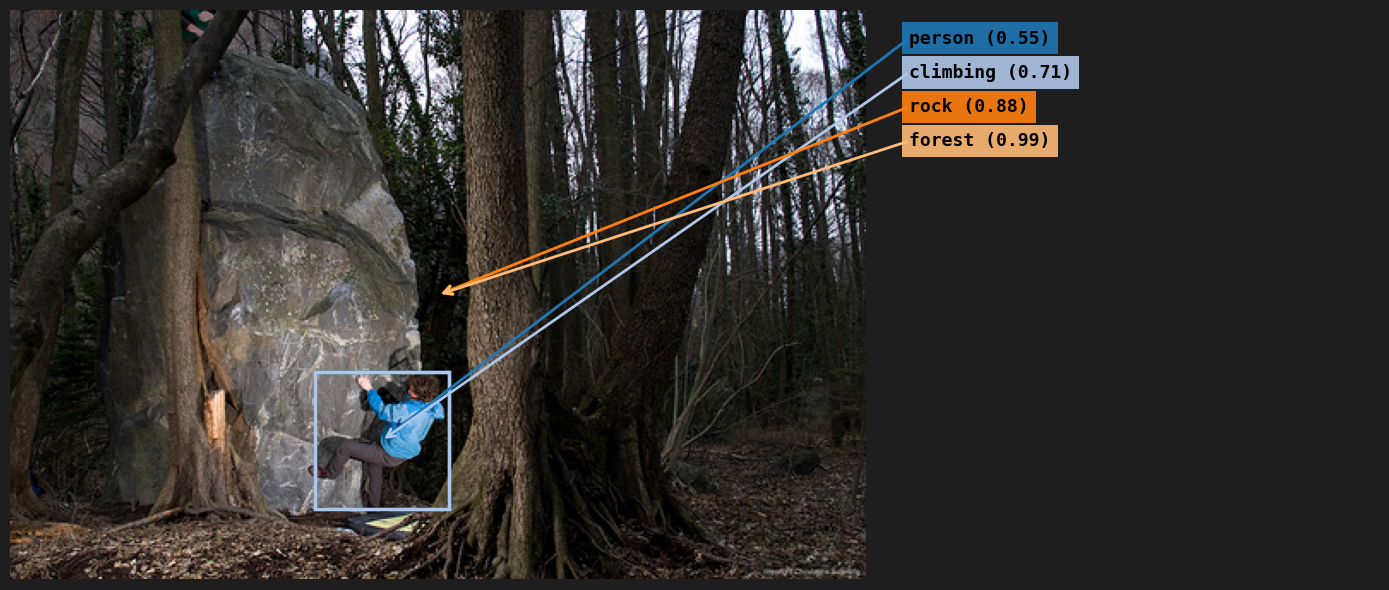

In [13]:
img_path, caption = random.choice(train_pairs)
visualize_alignment(img_path, caption, resnet, model_align, preprocess_align, DEVICE)